In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import time
from igraph import *

In [2]:
def spread(g,S,p=0.5,mc=1000):
    
    sprd = []
    
    for i in range(mc):
        new_active, A = S[:], S[:]
    
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
            # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
        
        sprd.append(len(A))
        
    return np.mean(sprd)

In [3]:
def IC(g,S,AR,p=0.5,mc=1000):
    
    # Loop over the Monte-Carlo Simulations
    spread1 = []
    spread2 = []
    for i in range(mc):
        
        # Simulate propagation process      
        R_active, A = S[:], S[:]
        AR_active, B = AR[:], AR[:]
        while R_active or AR_active:

            # For each newly active node, find its neighbors that become activated
            new_ones_R = []
            new_ones_AR = []
            for node in R_active:
                # Finding neighbors that are positively active
                neighbors = g.neighbors(node,mode="out")
                for node in neighbors:
                    if node in AR_active:
                        neighbors.remove(node)

                # Determine neighbors that become infected
                np.random.seed(i)        
                success = np.random.uniform(0,1,len(neighbors)) < p
                new_ones_R += list(np.extract(success, neighbors))

            for node in AR_active:
                # Finding neighbors which are already infected
                neighbors = g.neighbors(node,mode="out")
                for node in neighbors:
                    if node in R_active:
                        neighbors.remove(node)
                        
                # Determine neighbors that become positively active
                np.random.seed(mc+i)
                success = np.random.uniform(0,1,len(neighbors)) < p
                new_ones_AR += list(np.extract(success, neighbors))
            
            # Remove neighbors which are already infected
            for n in new_ones_AR:
                if n in new_ones_R:
                    new_ones_AR.remove(n)
                    

            R_active = list(set(new_ones_R) - set(A))
            AR_active = list(set(new_ones_AR) - set(B))
            # Add newly activated nodes to the set of activated nodes
            A += R_active
            B += AR_active
            
        spread1.append(len(A))
        spread2.append(len(B))
        
    return ((np.mean(spread1), np.mean(spread2)))

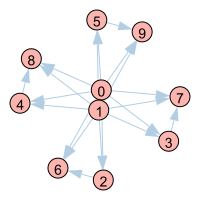

In [4]:
# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = Graph(directed=True)
g.add_vertices(range(10))
g.add_edges(zip(source,target))

# Plot graph
g.vs["label"], g.es["color"], g.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
plot(g,bbox = (200,200),margin = 20,layout = g.layout("fr"))
#plot(g)

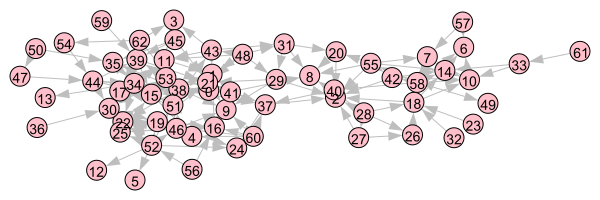

In [5]:
data = pd.read_csv("dolphins.txt", header=None, delimiter=" ")
v = list(data[0])
e = list(data[1])

size = max(max(v),max(e))+1

g1 = Graph(directed=True)
g1.add_vertices(size)
g1.add_edges(list(zip(v,e)))

g1.vs["color"], g1.es["color"], g1.vs["label"] = "pink", "grey", range(size)
g1.vs["name"] = g1.vs["label"]
plot(g1, bbox=(600,200), layout=g1.layout("kk"))

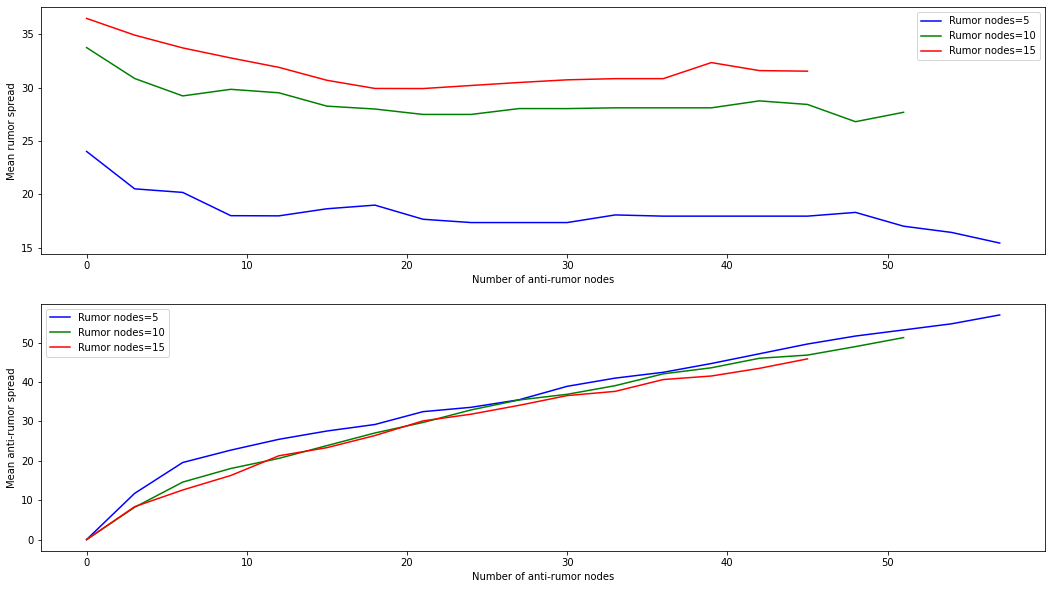

In [6]:
# MAX-DEGREE ALGORITHM
plt.figure(figsize=(18,10))

no_of_edges = len(g1.es)
no_of_vertices = len(g1.vs)
deg = {}                  # Key=node, value=out degree

for i in g1.vs['name']:
    deg[i] = g1.degree(i,mode="out")
deg = dict(sorted(deg.items(), key = lambda k: k[1], reverse=True))

# TAKING FIRST 5 NODES AS RUMOR ACTIVE
rumor = list(deg.keys())[:5]
l = []
o1 = list()
o2 = list()
for i in range(0,size-5,3):
    a_rumor = list(deg.keys())[5:5+i]
    m = IC(g1, rumor, a_rumor)
    l.append(i)
    o1.append(m[0])
    o2.append(m[1])
    
# RUMOR NODES = 10
rumor = list(deg.keys())[:10]
l2,p1,p2 = [],[],[]
for i in range(0,size-10,3):
    a_rumor = list(deg.keys())[10:10+i]
    m = IC(g1, rumor, a_rumor)    
    l2.append(i)
    p1.append(m[0])
    p2.append(m[1])
    
#RUMOR NODES = 15
rumor = list(deg.keys())[:15]
l3,q1,q2 = [],[],[]
for i in range(0,size-15,3):
    a_rumor = list(deg.keys())[15:15+i]
    m = IC(g1, rumor, a_rumor)    
    l3.append(i)
    q1.append(m[0])
    q2.append(m[1])

plt.subplot(2,1,1)
plt.plot(l,o1, color="blue", label="Rumor nodes=5")
plt.plot(l2,p1, color="green", label="Rumor nodes=10")
plt.plot(l3,q1, color="red", label="Rumor nodes=15")
plt.xlabel("Number of anti-rumor nodes")
plt.ylabel("Mean rumor spread")
#plt.title("Fig.1 Mean rumor spread")
plt.legend()

plt.subplot(2,1,2)
plt.plot(l,o2, color="blue", label="Rumor nodes=5")
plt.plot(l2,p2, color="green", label="Rumor nodes=10")
plt.plot(l3,q2, color="red", label="Rumor nodes=15")
plt.xlabel("Number of anti-rumor nodes")
plt.ylabel("Mean anti-rumor spread")
#plt.title("Fig.2 Mean anti-rumor spread")
plt.legend()
plt.show()

In [25]:
r = [15, 12, 2]
a = [23,15,3,8,24]
IC(g1,r,a)

(20.152, 19.581)